In [86]:
import pickle
import os

out_dir = ""
block_size = 256
eval_batch_size = 16
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler,TensorDataset


In [87]:
import  json
import logging
logger = logging.getLogger(__name__)
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 label,

                 ):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.label=label


def convert_examples_to_features(js,tokenizer):
    #source
    code=' '.join(js['code'].split())
    code_tokens=tokenizer.tokenize(code)[:block_size-2]
    source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = block_size - len(source_ids)
    source_ids+=[tokenizer.pad_token_id]*padding_length
    return InputFeatures(source_tokens,source_ids,js['label'])

class TextDataset(Dataset):
    def __init__(self, tokenizer, file_path=None):
        self.examples = []
        with open(file_path) as f:
            for line in f:
                js=json.loads(line.strip())
                self.examples.append(convert_examples_to_features(js,tokenizer))
        if 'train' in file_path:
            for idx, example in enumerate(self.examples[:3]):
                logger.info("*** Example ***")
                logger.info("label: {}".format(example.label))
                logger.info("input_tokens: {}".format([x.replace('\u0120','_') for x in example.input_tokens]))
                logger.info("input_ids: {}".format(' '.join(map(str, example.input_ids))))
    def __len__(self):
        return len(self.examples)
    def __getitem__(self, i):
        return torch.tensor(self.examples[i].input_ids),torch.tensor(self.examples[i].label)
    def get_true_labels(self):
        true_labels = []
        for e in self.examples:
            true_labels.append(e.label)
        return true_labels




In [88]:
import torch
import torch.nn as nn
import torch
from torch.autograd import Variable
import copy
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss


class Model(nn.Module):
    def __init__(self, encoder,config,tokenizer,args):
        super(Model, self).__init__()
        self.encoder = encoder
        self.config=config
        self.tokenizer=tokenizer
        self.args=args


    def forward(self, input_ids=None,labels=None):
        logits=self.encoder(input_ids,attention_mask=input_ids.ne(1))[0]
        prob=torch.softmax(logits,-1)
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-1)
            loss = loss_fct(logits,labels)
            return loss,prob
        else:
            return prob





In [108]:
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
import torch
from tqdm import tqdm
import numpy as np



def calculate_f1_score(model_name):
    tokenizer_name = "microsoft/codebert-base"
    test_data_file = "/Users/lfeliped/pipe/master/experiments/jsonl/test.jsonl"
    # test_data_file = "./jsonl/test.jsonl"
    config = RobertaConfig.from_pretrained(model_name)
    config.num_labels=100
    model = RobertaForSequenceClassification.from_pretrained(model_name,config=config)
    tokenizer = RobertaTokenizer.from_pretrained(tokenizer_name)
    model = Model(model, config, tokenizer, {})
    eval_dataset = TextDataset(tokenizer,test_data_file)
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=eval_batch_size)

    outputs = []
    checkpoint_location = "/Users/lfeliped/Downloads/CodeBERT-classification/code/saved_models/codebert/checkpoint-best-acc/model.bin"
    model.load_state_dict(torch.load(checkpoint_location))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    with torch.no_grad():
        model.eval()
        logits=[]
        labels=[]
        for batch in tqdm(eval_dataloader,total=len(eval_dataloader)):
            inputs = batch[0].to(device)
            label= batch[1].to(device)
            with torch.no_grad():
                logit = model(inputs)
                logits.append(logit.cpu().numpy())
                labels.append(label.cpu().numpy())
        logits=np.concatenate(logits,0)
        labels=np.concatenate(labels,0)

        true_values =eval_dataset.get_true_labels()
        true_values = np.array(true_values)
        preds = logits.argmax(-1)
        test_accuracy = np.sum(preds == true_values) / len(true_values)
        print ("Test Accuracy:", test_accuracy)
        return true_values, preds


In [109]:
import itertools
import matplotlib.pyplot as plt
# plot confusion matrix
# code borrowed from scikit-learn.org
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

F1 score model microsoft/codebert-base


Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be 

Test Accuracy: 0.9719163676852653
                  precision    recall  f1-score   support

      awsservice       0.98      0.98      0.98      2250
      serverless       0.97      0.97      0.97      1738
  object-storage       0.94      0.95      0.95       970
   microservices       0.96      0.97      0.97       570
    event-driven       0.99      0.98      0.99      2009
   nosql-storage       0.92      0.96      0.94       389
             iot       0.85      0.96      0.90        74
batch-processing       0.90      0.60      0.72        15
       streaming       0.80      0.67      0.73        24
  data-warehouse       1.00      0.95      0.98        21
        big-data       0.65      0.72      0.68        18
       data-orch       0.00      0.00      0.00         5

        accuracy                           0.97      8083
       macro avg       0.83      0.81      0.82      8083
    weighted avg       0.97      0.97      0.97      8083

Confusion matrix, without normaliza

Some weights of the model checkpoint at microsoft/unixcoder-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/unixcoder-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to b

RuntimeError: Error(s) in loading state_dict for Model:
	size mismatch for encoder.roberta.embeddings.position_ids: copying a param with shape torch.Size([1, 514]) from checkpoint, the shape in current model is torch.Size([1, 1026]).
	size mismatch for encoder.roberta.embeddings.word_embeddings.weight: copying a param with shape torch.Size([50265, 768]) from checkpoint, the shape in current model is torch.Size([51416, 768]).
	size mismatch for encoder.roberta.embeddings.position_embeddings.weight: copying a param with shape torch.Size([514, 768]) from checkpoint, the shape in current model is torch.Size([1026, 768]).
	size mismatch for encoder.roberta.embeddings.token_type_embeddings.weight: copying a param with shape torch.Size([1, 768]) from checkpoint, the shape in current model is torch.Size([10, 768]).

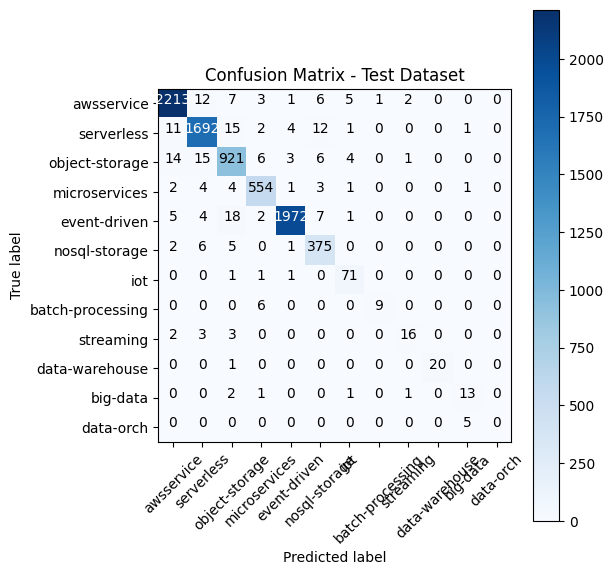

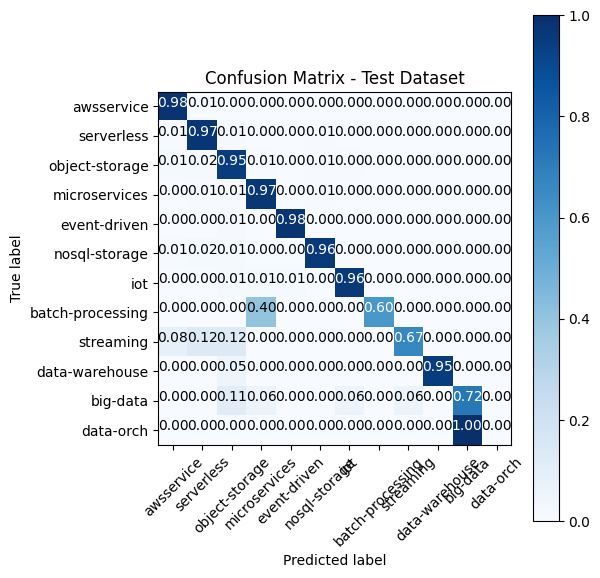

In [110]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix

label_values = [
    'awsservice', 'serverless', 'object-storage', 'microservices', 'event-driven', 'nosql-storage', 'iot', 'batch-processing', 'streaming', 'data-warehouse', 'big-data', 'data-orch'
]
model_names = ["microsoft/codebert-base", "microsoft/unixcoder-base", "Salesforce/codet5-base", "roberta-base"]
for model_n in model_names:
    print("F1 score model", model_n)
    real_values, predictions= calculate_f1_score(model_n)
    print(classification_report(real_values, predictions, target_names=label_values))

    cm_test = confusion_matrix(real_values, predictions)

    np.set_printoptions(precision=2)

    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
    plt.figure(figsize=(6,6))
    plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)

Confusion matrix, without normalization
[[2213   12    7    3    1    6    5    1    2    0    0    0]
 [  11 1692   15    2    4   12    1    0    0    0    1    0]
 [  14   15  921    6    3    6    4    0    1    0    0    0]
 [   2    4    4  554    1    3    1    0    0    0    1    0]
 [   5    4   18    2 1972    7    1    0    0    0    0    0]
 [   2    6    5    0    1  375    0    0    0    0    0    0]
 [   0    0    1    1    1    0   71    0    0    0    0    0]
 [   0    0    0    6    0    0    0    9    0    0    0    0]
 [   2    3    3    0    0    0    0    0   16    0    0    0]
 [   0    0    1    0    0    0    0    0    0   20    0    0]
 [   0    0    2    1    0    0    1    0    1    0   13    0]
 [   0    0    0    0    0    0    0    0    0    0    5    0]]
Normalized confusion matrix
[[9.84e-01 5.33e-03 3.11e-03 1.33e-03 4.44e-04 2.67e-03 2.22e-03 4.44e-04
  8.89e-04 0.00e+00 0.00e+00 0.00e+00]
 [6.33e-03 9.74e-01 8.63e-03 1.15e-03 2.30e-03 6.90e-03 5.75e-

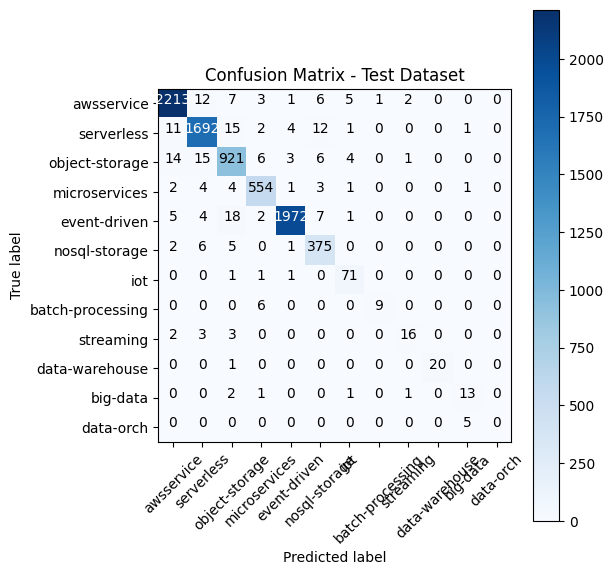

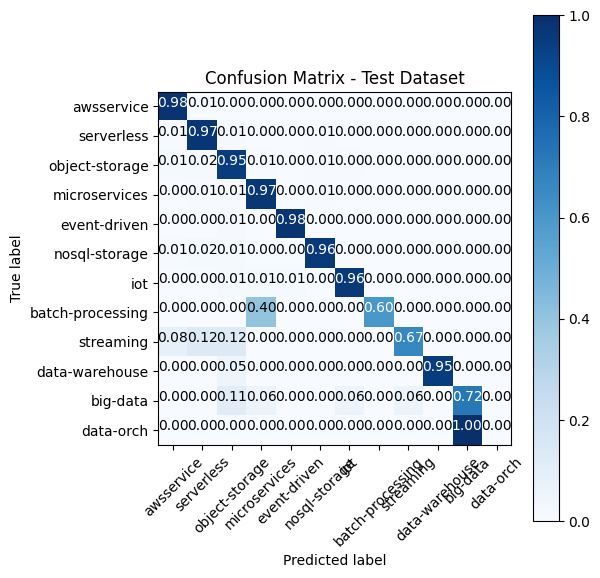